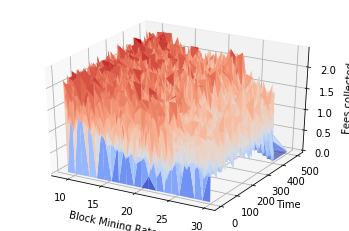

In [2]:
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import bisect as bi
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def Simulate(mu, k):
  lambda_ = 120
  t_end = 500

  # Store data for plot (you can store whatever data you like in lists like this)
  times = []
  Number_of_Transactions = []
  Transaction_queue= []
  Transaction_amounts = []
  Transaction_times = []
  Fee_amounts = []
  Block_times = []


  # General discrete-event loop
  # Initialize times
  currenttime = 0
  c_time = 0
  #Transaction_arrival = np.random.poisson(lambda_)
  #Block_arrival = np.random.poisson(mu)

  #generate transaction times and amounts
  while currenttime < t_end:
  
    #print("Transaction Arrives")
    next_transaction_time = currenttime + np.random.exponential(1.0/lambda_)

    #determine Transaction Amount and fees
    t_amount = np.random.randint(5,25)
    u = np.random.uniform(0,1)
    if u <= 0.5:
      t_fee = 0.01*t_amount
    else:
      t_fee = 0.02*t_amount


    Transaction_times.append(next_transaction_time)
    Fee_amounts.append(t_fee)
    Transaction_amounts.append(t_amount)
  
    currenttime = next_transaction_time

  #generate times where blocks are mined
  while c_time < t_end:
  
    next_block_time = c_time + np.random.exponential(1.0/mu)
  
    Block_times.append(next_block_time)
    c_time = next_block_time
   
  all_blocks = []
  #print('working')
  #Transactions of current blocks in this format:
  #[block_time,[t_time,t_value,f_value] . . . [t_time,t_value,f_value]]
  TransactionsOfB = []
  Transactions = 0 #Throughput Number of Transactions
  BRCs = 0 #Throughput BRCs
  Delay_start = [] #Delay Starting Time
  Delay_length = [] #Delay Duration
  Block_t = [] #Block Time
  Fee = [] #$ Collected During Block
  current_b = 0
  current_t = []
  current_t2 = []
  length_of_queue=[]
  rrr = 0

  while len(Block_times) != 0:
      #block time
      Block_t.append(current_b)
      Fee.append(rrr)
      current_b = Block_times.pop(0)
      rrr = 0
      TransactionsOfB.append(current_b)
      #where is the time for block arrival
      split = bi.bisect_left(Transaction_times,current_b)
      #current fee values for prior to block time
      current_f = Fee_amounts[0:split]
      #length of current_f
      k_track = len(current_f)
      #iterate until k reached or current_f empty
      while (k_track-len(current_f) != k) and (len(current_f) > 0):
          #where is max f
          f_max = np.argmax(current_f)
          #remove values at f_max indicies for all value lisst
          current_t.append(Transaction_times.pop(f_max))
          Transactions = Transactions + 1
          current_t.append(Transaction_amounts.pop(f_max))
          BRCs = BRCs + current_t[1]
          current_t.append(Fee_amounts.pop(f_max))
          #remove f_max indicie from current_f
          current_f.pop(f_max)
          #add current_t to Transactions of current Block
          TransactionsOfB.append(current_t)
          r = current_t[0]
          Delay_start.append(r)
          rr = current_b - r
          if rr > 0:
            Delay_length.append(rr)
          else:
            Delay_length.append(0)
  #        if (k_track==k):
  #            print(current_t)
          #reinitialize current_t
          rrr = rrr + current_t[2]
          current_t = []
      length_of_queue.append(len(current_f))
      #add current block to all_blocks list  
      #Check if K is upheld, if not fill block until k transactions is added
      add = k - k_track
      if k_track < k and len(Transaction_times) >= add:
          for i in range(add):
              current_t2.append(Transaction_times.pop(0))
              Transactions = Transactions + 1
              current_t2.append(Transaction_amounts.pop(0))
              BRCs = BRCs + current_t2[1]
              current_t2.append(Fee_amounts.pop(0))
              TransactionsOfB.append(current_t2)
              r = current_t2[0]
              Delay_start.append(r)
              rr = current_b - r
              if rr > 0:
                Delay_length.append(rr)
              else:
                Delay_length.append(0)
              rrr = rrr + current_t2[2]
              current_t2 = []
         
      #add current block onto counter    
      all_blocks.append(TransactionsOfB)
      TransactionsOfB = []
  #print(all_blocks)
  return [Transactions, BRCs, Delay_start[::50], Delay_length[::50], Block_t[::10], Fee[::10]]
  
def Output(K, G):
  if G==1:
    MU = []
    TPnum = []
    TPBRC = []
    for u in np.linspace(9,30,20):
      Slice = Simulate(u, K)
      MU.append(u)
      TPnum.append(Slice[0])
      TPBRC.append(Slice[1])
    fig = plt.figure(figsize=plt.figaspect(2.))
    fig.suptitle('Throughput')
    ax = fig.add_subplot(2, 1, 1)
    l = ax.plot(MU, TPnum, '-', markerfacecolor='green')
    ax.grid(True)
    ax.set_xlabel('Block Mining Rate')
    ax.set_ylabel('Number of Transactions')
    
    fig = plt.figure(figsize=plt.figaspect(2.))
    
    ax = fig.add_subplot(2, 1, 2)
    l = ax.plot(MU, TPBRC, '-', markerfacecolor='green')
    ax.grid(True)
    ax.set_xlabel('Block Mining Rate')
    ax.set_ylabel('Total BRCs')
    plt.show()
  
  elif G==2:
    MU = []
    Time = []
    Delay = []
    for u in np.linspace(9,30,20):
      Slice = Simulate(u, K)
      for S in Slice[2]:
        MU.append(u)
      Time = Time + Slice[2]
      Delay = Delay + Slice[3]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(MU, Time, Delay, linewidth=0.2, cmap=cm.coolwarm, antialiased=True)
    #ax.scatter(Time, MU, Delay, marker='.')
    ax.set_xlabel('Block Mining Rate', labelpad=6)
    ax.set_ylabel('Time')
    ax.set_zlabel('Delay experienced')
    plt.show()
    
  elif G==3:
    MU = []
    Time = []
    Fees = []
    for u in np.linspace(9,30,20):
      Slice = Simulate(u, K)
      for S in Slice[4]:
        MU.append(u)
      Time = Time + Slice[4]
      Fees = Fees + Slice[5]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(MU, Time, Fees, linewidth=0.2, cmap=cm.coolwarm, antialiased=True)
    #ax.scatter(Time, MU, Fees, marker='.')
    ax.set_xlabel('Block Mining Rate', labelpad=6)
    ax.set_ylabel('Time')
    ax.set_zlabel('Fees collected')
    plt.show()
  

Output(5,3)
    